In [36]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math


# Parameters
n = 500  # Number of nodes
k = 6  # Each node connects to 4 neighbors
beta = 0.25  # Infection probability
rho = 0.6  # Recovery probability
weeks = 16  # Number of weeks for simulation
initial_infected = 10  # Initial number of infected nodes


_______
_______
____

##### GRAPH GENERATORS 

In [37]:
def generate_k_regular_graph(n, k):
    """
    Generates a symmetric k-regular graph.

    Parameters:
        n (int): Number of nodes.
        k (int): Each node connects to k neighbors.

    Returns:
        np.ndarray: Adjacency matrix of the k-regular graph.
    """
    if k >= n or k % 2 != 0:
        raise ValueError("k must be even and less than n.")
    
    adjacency_matrix = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(1, k // 2 + 1):  # Connect to k/2 neighbors on each side
            adjacency_matrix[i, (i + j) % n] = 1
            adjacency_matrix[(i + j) % n, i] = 1
    return adjacency_matrix


In [38]:
def generate_preferential_attachment(n, k):
    """
    Generates a graph using the preferential attachment model.

    Parameters:
        n (int): Total number of nodes.
        k (int): Average degree of the nodes.

    Returns:
        np.ndarray: Adjacency matrix of the graph.
    """
    # Start with a complete graph of `k` nodes
    adjacency_matrix = np.zeros((n, n), dtype=int)
    degrees = np.zeros(n, dtype=int)

    # Step 1: Start with a fully connected graph of `k` nodes
    for i in range(k):
        for j in range(i + 1, k):
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1
    degrees[:k] = k - 1  # Each initial node is connected to (k-1) others

    # Step 2: Add remaining nodes
    for new_node in range(k, n):
        # Compute probabilities for connecting to existing nodes
        probabilities = degrees[:new_node] / degrees[:new_node].sum()

        # Select `k` targets based on probabilities
        targets = np.random.choice(
            range(new_node), size=k, replace=False, p=probabilities
        )

        # Connect new node to targets and update degrees
        for target in targets:
            adjacency_matrix[new_node, target] = 1
            adjacency_matrix[target, new_node] = 1
            degrees[target] += 1
        degrees[new_node] = k

    return adjacency_matrix


____
##### PLOTNG

In [39]:
def plot_graph(adjacency_matrix, file=None, name=''):
    """
    Plots the graph using NetworkX and Matplotlib in a circular layout.

    Parameters:
        adjacency_matrix (np.ndarray): Adjacency matrix of the graph.
    """
    # Convert adjacency matrix to a NetworkX graph
    G = nx.from_numpy_array(adjacency_matrix)
    
    # Use a circular layout for the graph
    pos = nx.circular_layout(G)
    
    # Plot the graph
    plt.figure(figsize=(8, 5))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(name+" (Circular Layout)")
    if file != None:
        plt.savefig(name+'.jpg')
    plt.show()


In [40]:
def plot_avg_results(data, labels, file=None, name=""):
    plt.figure(figsize=(15, 6))
    for i in range(len(data)):    
        plt.plot(data[i], label=labels[i],marker=".")
    plt.xlabel("Weeks")
    plt.ylabel("Number of Individuals")
    plt.title("Average Epidemic Dynamics Over 100 Simulations")
    plt.legend()
    plt.grid()
    if file != None:
        plt.savefig(name+".jpg")
    plt.show()


In [41]:
def plot_newly_infected_vaccinated(ni, nv=None, file=None, name=''):
    """
    Plot newly infected and optionally newly vaccinated nodes over time.
    
    Parameters:
        ni (np.ndarray): Array of newly infected counts per week.
        nv (np.ndarray, optional): Array of newly vaccinated counts per week.
        file (str, optional): File path to save the plot. If None, display the plot.
    """
    if nv is not None:
        fig, ax = plt.subplots(figsize=(15, 6))

        ticks = np.arange(0, ni.shape[0], dtype=int)

        ax.plot(ticks, ni, color="#1A7CDE", label="newly Infected", marker=".")
        ax.plot(ticks, nv, color="#A71C1C", label="newly Vaccinated", marker=".")

        ax.set_xticks(ticks)
        ax.set_xlabel('Week')
        ax.set_ylabel('Number of nodes')
        ax.grid(alpha=0.3)
        ax.legend()

        if file:
            plt.title("Newly infected and vaccinated nodes")
            plt.savefig(name+".pdf")
        else:
            plt.show()
    else:
        fig, ax = plt.subplots(figsize=(15, 6))

        ticks = np.arange(0, ni.shape[0], dtype=int)

        ax.plot(ticks, ni, color="#1A7CDE", label="newly Infected", marker=".")

        ax.set_xticks(ticks)
        ax.set_xlabel('Week')
        ax.set_ylabel('Number of newly infected/vaccinated nodes')
        ax.grid(alpha=0.3)
        ax.legend()

        if file:
            plt.title("Newly infected nodes")
            plt.savefig(name+".jpg")
        else:
            plt.show()


In [42]:
def plot_comparison_modeled_real_data(simulated, true , file=None, name=''):

    fig, ax = plt.subplots(figsize=(15, 6))

    ticks = np.arange(0, simulated.shape[0], dtype=int)

    ax.plot(ticks, simulated, color="#1A7CDE", label="Modeled Data", marker=".")
    ax.plot(ticks, true, color="#FF4800", label="True Data", marker=".")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of nodes')
    ax.grid(alpha=0.3)
    ax.legend()

    if file:
        plt.title("Real And Simulation Infected Data Comparison")
        plt.savefig(name+".jpg",dpi=100)
    else:
        plt.show()


______
##### MODEL'S SIMULATION

In [43]:
def simulate_SIR(adjacency_matrix, beta, rho, weeks, initial_infected):
    """
    Simulate the SIR epidemic model.

    Parameters:
        adjacency_matrix (np.ndarray): Graph adjacency matrix.
        beta (float): Infection probability.
        rho (float): Recovery probability.
        weeks (int): Number of weeks to simulate.
        initial_infected (int): Number of initially infected nodes.

    Returns:
        tuple: Arrays representing susceptible, infected, and recovered counts over time.
    """
    n = len(adjacency_matrix)
    states = np.zeros(n, dtype=int)  # 0: Susceptible, 1: Infected, 2: Recovered
    initial_nodes = np.random.choice(n, initial_infected, replace=False)
    states[initial_nodes] = 1  # Infect initial nodes

    # Track the number of individuals in each state
    susceptible = [n - initial_infected]
    infected = [initial_infected]
    recovered = [0]

    for _ in range(weeks):
        new_states = states.copy()
        for i in range(n):
            if states[i] == 0:  # Susceptible
                neighbors = np.where(adjacency_matrix[i] == 1)[0]
                infected_neighbors = np.sum(states[neighbors] == 1)
                if np.random.rand() < 1 - (1 - beta) ** infected_neighbors:
                    new_states[i] = 1  # Becomes infected
            elif states[i] == 1:  # Infected
                if np.random.rand() < rho:
                    new_states[i] = 2  # Recovers

        states = new_states
        susceptible.append(np.sum(states == 0))
        infected.append(np.sum(states == 1))
        recovered.append(np.sum(states == 2))

    return np.array(susceptible), np.array(infected), np.array(recovered)


In [44]:
def simulate_SIRV(adjacency_matrix, beta, rho, weeks, initial_infected, vacc_schedule):
    """
    Simulate the SIRV epidemic model with vaccination.

    Parameters:
        adjacency_matrix (np.ndarray): Graph adjacency matrix.
        beta (float): Infection probability.
        rho (float): Recovery probability.
        weeks (int): Number of weeks to simulate.
        initial_infected (int): Number of initially infected nodes.
        vacc_schedule (list): List of percentages (0-100) for vaccination per week.

    Returns:
        tuple: Arrays representing susceptible, infected, recovered, and vaccinated counts over time.
    """
    n = len(adjacency_matrix)
    states = np.zeros(n, dtype=int)  # 0: Susceptible, 1: Infected, 2: Recovered, 3: Vaccinated
    initial_nodes = np.random.choice(n, initial_infected, replace=False)
    states[initial_nodes] = 1  # Infect initial nodes

    # Track the number of individuals in each state
    susceptible = [n - initial_infected]
    infected = [initial_infected]
    recovered = [0]
    vaccinated = [0]

    for week in range(weeks):
        new_states = states.copy()

        # Vaccinate individuals
        num_to_vaccinate = int((vacc_schedule[week] / 100) * n) - vaccinated[-1]
        if num_to_vaccinate > 0:
            vacc_candidates = np.where(states == 0)[0]  # Only susceptible individuals
            if len(vacc_candidates) > 0:
                vaccinated_nodes = np.random.choice(vacc_candidates, min(num_to_vaccinate, len(vacc_candidates)), replace=False)
                new_states[vaccinated_nodes] = 3  # Vaccinated

        for i in range(n):
            if states[i] == 0:  # Susceptible
                neighbors = np.where(adjacency_matrix[i] == 1)[0]
                infected_neighbors = np.sum(states[neighbors] == 1)
                if np.random.rand() < 1 - (1 - beta) ** infected_neighbors:
                    new_states[i] = 1  # Becomes infected
            elif states[i] == 1:  # Infected
                if np.random.rand() < rho:
                    new_states[i] = 2  # Recovers

        states = new_states
        susceptible.append(np.sum(states == 0))
        infected.append(np.sum(states == 1))
        recovered.append(np.sum(states == 2))
        vaccinated.append(np.sum(states == 3))

    return np.array(susceptible), np.array(infected), np.array(recovered), np.array(vaccinated)


In [45]:
def simulate_epidemic(adjacency_matrix, beta, rho, weeks, initial_infected, vaccination_schedule=None):
    """
    Simulate an epidemic in a discrete-time SIR or SIRV model with vaccinations.

    States:
    S = 0
    I = 1
    R = 2
    V = 3

    Args:
        adjacency_matrix (np.ndarray): Adjacency matrix representing the graph structure.
        beta (float): Probability of infection spread from an infected node to a susceptible node.
        rho (float): Probability of recovery of an infected node in one time step.
        weeks (int): Number of simulation steps (weeks).
        initial_infected (int): Number of initially infected nodes chosen randomly.
        vaccination_schedule (list): Percentage of the population vaccinated at each step.

    Returns:
        tuple: Arrays of susceptible, infected, recovered, and optionally vaccinated counts over time.
    """
    n_nodes = adjacency_matrix.shape[0]
    states = np.zeros(n_nodes, dtype=int)  # 0: Susceptible, 1: Infected, 2: Recovered, 3: Vaccinated

    # Initialize infected nodes
    initial_nodes = np.random.choice(n_nodes, initial_infected, replace=False)
    states[initial_nodes] = 1

    # Tracking state counts
    susceptible = np.zeros(weeks, dtype=int)
    infected = np.zeros(weeks, dtype=int)
    recovered = np.zeros(weeks, dtype=int)
    new_infected = np.zeros(weeks, dtype=int)
    vaccinated = np.zeros(weeks, dtype=int) if vaccination_schedule else None
    new_vaccinated = np.zeros(weeks, dtype=int) if vaccination_schedule else None

    # Initial counts
    susceptible[0] = n_nodes - initial_infected
    infected[0] = initial_infected
    recovered[0] = 0
    new_infected[0] = initial_infected
    
    if vaccination_schedule:
        vaccinated[0] = 0

    # Simulation loop
    for week in range(1, weeks):
        week_new_infected = 0

        # Vaccination step (if applicable)
        if vaccination_schedule:
            target_vaccination = int(n_nodes * vaccination_schedule[week - 1] / 100)
            current_vaccinated = vaccinated[week - 1]
            if target_vaccination > current_vaccinated:
                to_vaccinate = target_vaccination - current_vaccinated
                candidates = np.where(states == 0)[0]  # Only vaccinate susceptible nodes
                if len(candidates) > 0:
                    vaccinated_nodes = np.random.choice(candidates, min(to_vaccinate, len(candidates)), replace=False)
                    states[vaccinated_nodes] = 3  # Vaccinate nodes
                    new_vaccinated[week] = len(vaccinated_nodes)

        # Infection and recovery step
        new_states = states.copy()
        for node in range(n_nodes):
            if states[node] == 0:  # Susceptible
                neighbors = np.where(adjacency_matrix[node] == 1)[0]
                infected_neighbors = np.sum(states[neighbors] == 1)
                if infected_neighbors > 0:
                    infection_prob = 1 - (1 - beta) ** infected_neighbors
                    if np.random.rand() < infection_prob:
                        new_states[node] = 1  # Becomes infected
                        week_new_infected += 1

            elif states[node] == 1:  # Infected
                if np.random.rand() < rho:
                    new_states[node] = 2  # Recovers

        # Update states
        states = new_states

        # Update counts
        susceptible[week] = np.sum(states == 0)
        infected[week] = np.sum(states == 1)
        recovered[week] = np.sum(states == 2)
        if vaccination_schedule:
            vaccinated[week] = vaccinated[week - 1] + new_vaccinated[week]
        new_infected[week] = week_new_infected

    if vaccination_schedule:
        return susceptible, infected, recovered, new_infected, vaccinated, new_vaccinated
    else:
        return susceptible, infected, recovered, new_infected


___
___
___
### PROBLEM.1.1

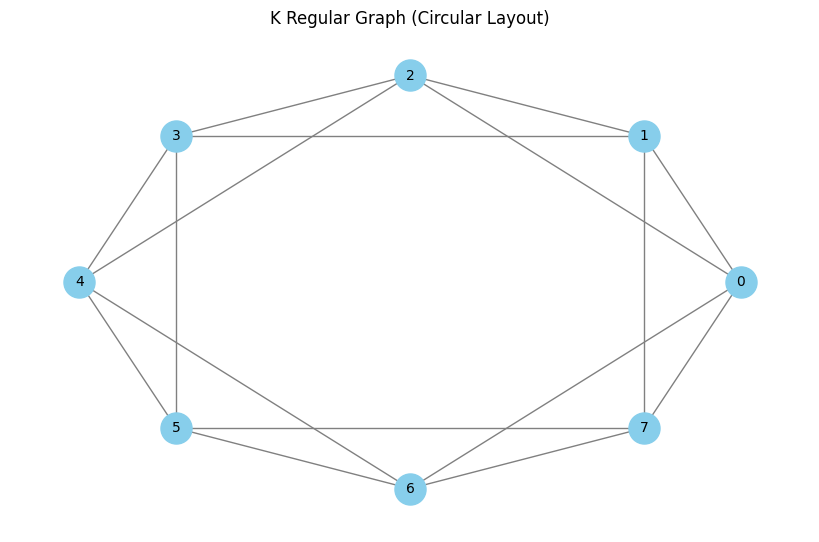

In [46]:
n = 8
k = 4

adjacency_matrix = generate_k_regular_graph(n, k)

plot_graph(adjacency_matrix,name="K Regular Graph",file=1)

In [47]:
# Parameters
n = 500  # Number of nodes
k = 6  # Each node connects to 4 neighbors
beta = 0.25  # Infection probability
rho = 0.6  # Recovery probability
weeks = 16  # Number of weeks for simulation
initial_infected = 10  # Initial number of infected nodes

adjacency_matrix = generate_k_regular_graph(n, k)
 
# Perform N simulations
all_susceptible = []
all_infected = []
all_recovered = []
all_newly_infected = []
N = 100

for _ in range(N):
    # Simulate the epidemic
    susceptible, infected, recovered, new_infected = simulate_epidemic(
        adjacency_matrix, beta, rho, weeks, initial_infected
    )
    all_susceptible.append(susceptible)
    all_infected.append(infected)
    all_recovered.append(recovered)
    all_newly_infected.append(new_infected)


# Compute averages
avg_susceptible = np.mean(all_susceptible, axis=0)
avg_infected = np.mean(all_infected, axis=0)
avg_recovered = np.mean(all_recovered, axis=0)
avg_newly_infected = np.mean(all_newly_infected, axis=0)


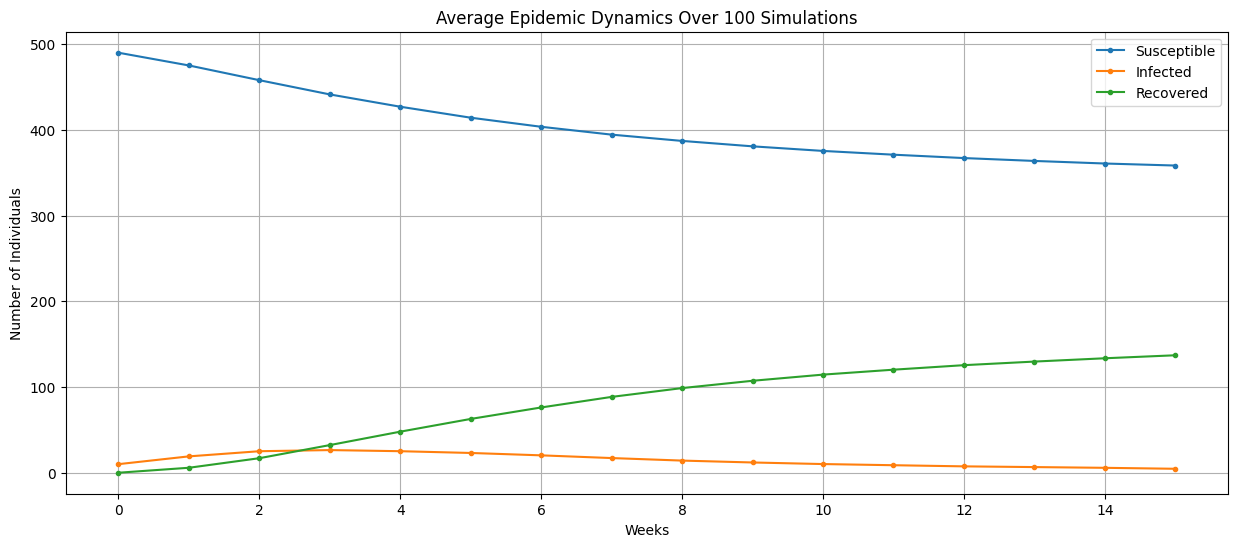

In [48]:
plot_avg_results([avg_susceptible, avg_infected, avg_recovered], 
                 ["Susceptible", "Infected", "Recovered"],file=1,name="problem_1_1_avg_results_fix_graph")

In [49]:
[round((i/n)* 100,1) for i in (avg_susceptible[-1], avg_infected[-1], avg_recovered[-1])]

[71.7, 0.9, 27.4]

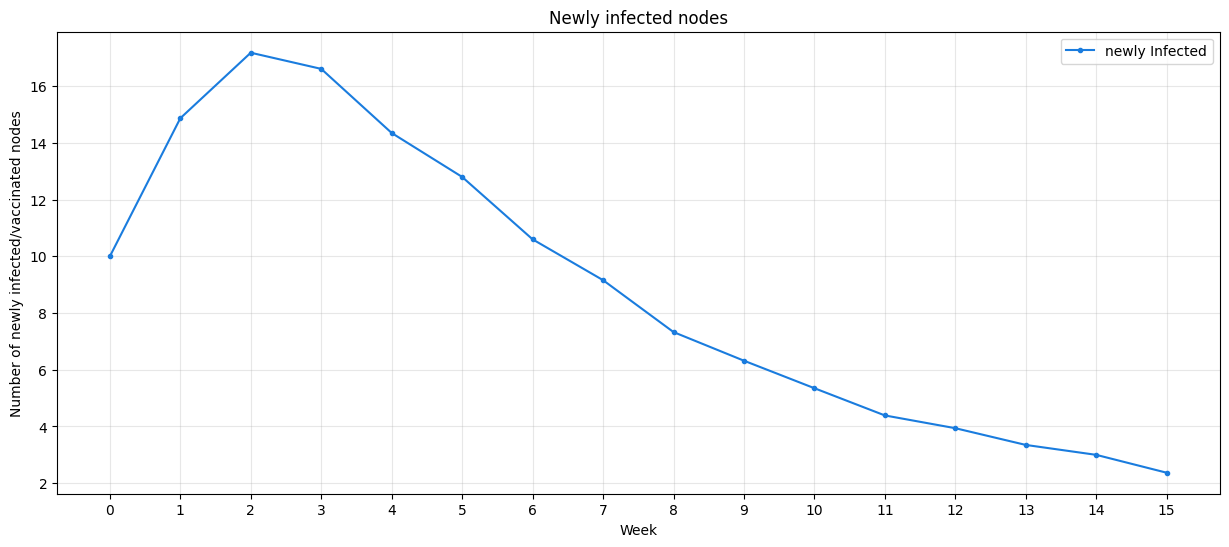

In [50]:
plot_newly_infected_vaccinated(avg_newly_infected, name="problem_1_1_newly_infected",file=1)


### PROBLEM.1.2

In [51]:
n = 8
k = 3

adjacency_matrix = generate_preferential_attachment(n, k)
w = np.sum(adjacency_matrix, axis=1)
print("Average degree: ", np.mean(w))

Average degree:  4.5


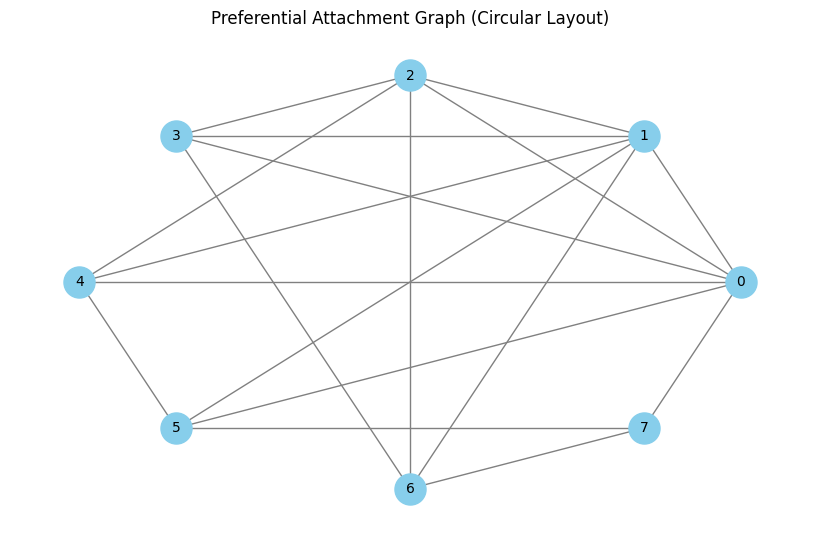

In [52]:
plot_graph(adjacency_matrix,name="Preferential Attachment Graph")

### PROBLEM.2

In [53]:
# Parameters
n = 500  # Number of nodes
k = 6  # Each node connects to 4 neighbors
beta = 0.25  # Infection probability
rho = 0.6  # Recovery probability
weeks = 16  # Number of weeks for simulation
initial_infected = 10  # Initial number of infected nodes


adjacency_matrix = generate_preferential_attachment(n, k)

# Perform N simulations
all_susceptible = []
all_infected = []
all_recovered = []
all_newly_infected = []


N = 100

for _ in range(N):
    adjacency_matrix = generate_preferential_attachment(n, k)
    # Simulate the epidemic
    susceptible, infected, recovered, new_infected = simulate_epidemic(
        adjacency_matrix, beta, rho, weeks, initial_infected
    )
    all_susceptible.append(susceptible)
    all_infected.append(infected)
    all_recovered.append(recovered)
    all_newly_infected.append(new_infected)


# Compute averages
avg_susceptible = np.mean(all_susceptible, axis=0)
avg_infected = np.mean(all_infected, axis=0)
avg_recovered = np.mean(all_recovered, axis=0)
avg_newly_infected = np.mean(all_newly_infected, axis=0)


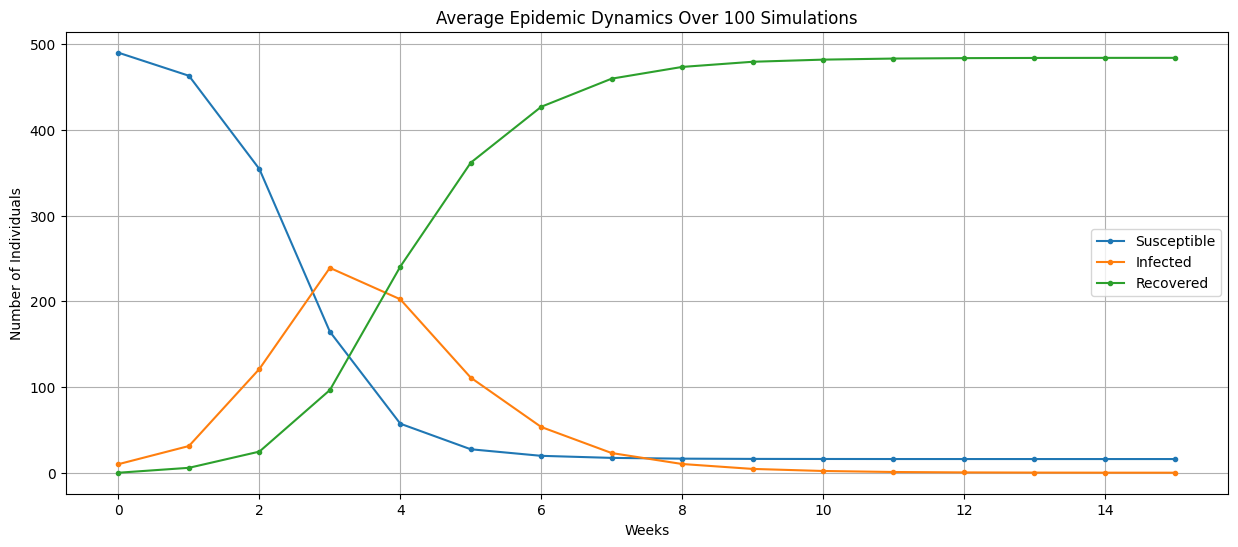

In [54]:
plot_avg_results([avg_susceptible, avg_infected, avg_recovered], 
                 ["Susceptible", "Infected", "Recovered"],file=1, name="problem_2_avg_results_preferential_attachment")

In [55]:
[round((i/n)* 100,1) for i in (avg_susceptible[-1], avg_infected[-1], avg_recovered[-1])]

[3.2, 0.0, 96.8]

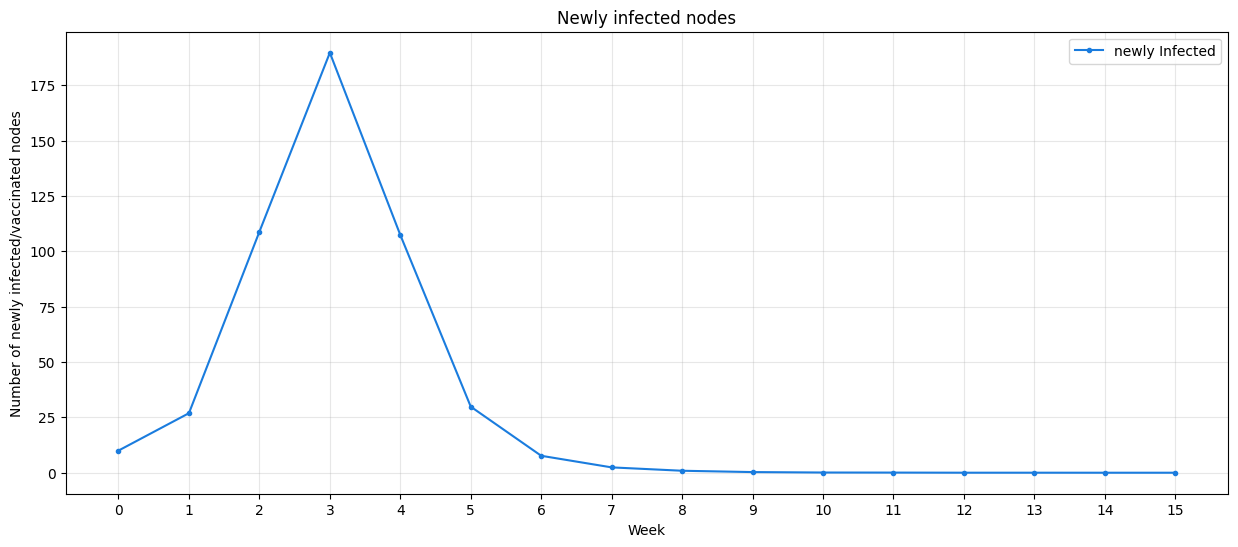

In [56]:
plot_newly_infected_vaccinated(avg_newly_infected,file=1, name="problem_2_newly_infected_preferential_attachment")

### PROBLEM.3

In [57]:
vaccination_vector = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]


 
# Perform N simulations
all_susceptible = []
all_infected = []
all_recovered = []
all_vaccinated = []
all_new_vaccinated = []
all_new_infected = []

N = 100

for _ in range(N):
    
    adjacency_matrix = generate_preferential_attachment(n, k)
    
    # Simulate the epidemic
    susceptible, infected, recovered, new_infected, vaccinated, new_vaccinated = simulate_epidemic(
        adjacency_matrix, beta, rho, weeks, initial_infected, vaccination_schedule=vaccination_vector
    )
    all_susceptible.append(susceptible)
    all_infected.append(infected)
    all_recovered.append(recovered)
    all_vaccinated.append(vaccinated)
    all_new_vaccinated.append(new_vaccinated)
    all_new_infected.append(new_infected)


# Compute averages
avg_susceptible = np.mean(all_susceptible, axis=0)
avg_infected = np.mean(all_infected, axis=0)
avg_recovered = np.mean(all_recovered, axis=0)
avg_vaccinated = np.mean(all_vaccinated, axis=0)
avg_newly_infected = np.mean(all_new_infected, axis=0)
avg_newly_vaccinated = np.mean(all_new_vaccinated, axis=0)



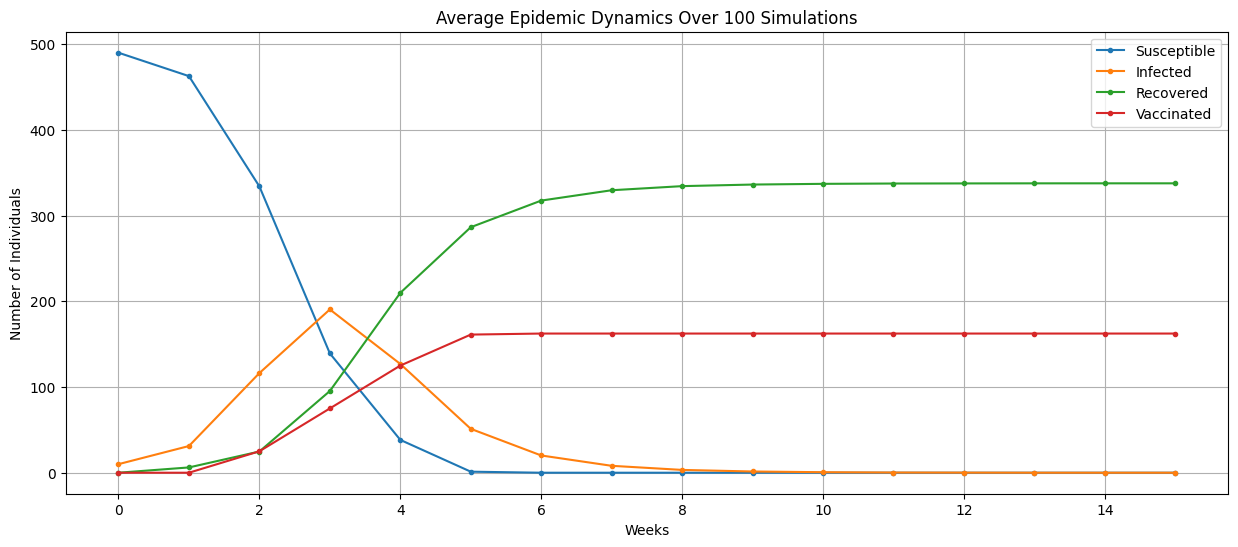

In [58]:
plot_avg_results([avg_susceptible, avg_infected, avg_recovered, avg_vaccinated], 
                 ["Susceptible", "Infected", "Recovered", "Vaccinated"],file=1, name="problem_3_avg_results_preferential_attachment")

In [59]:
[round((i/n)* 100,1) for i in (avg_susceptible[-1], avg_infected[-1], avg_recovered[-1],avg_vaccinated[-1])]

[0.0, 0.0, 67.5, 32.5]

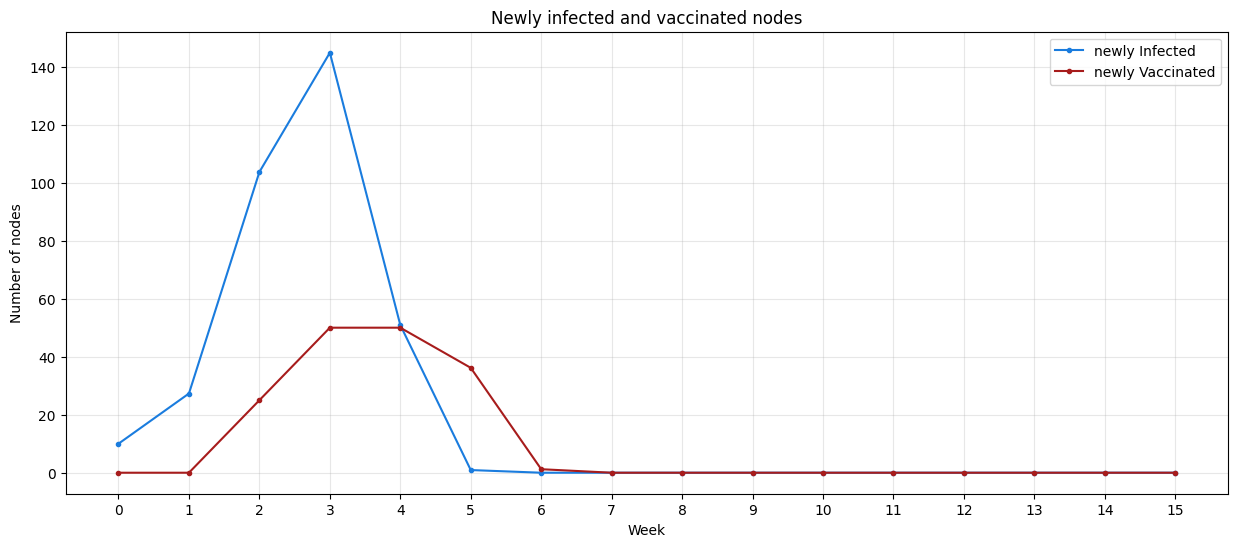

In [60]:
plot_newly_infected_vaccinated(avg_newly_infected, avg_newly_vaccinated,file=1, name="problem_3_newly_infected_preferential_attachment")